HW3 Group 3   
Abhishek Kumar [kumar.abhishek@ischool.berkeley.edu](mailto:kumar.abhishek@ischool.berkeley.edu)   
Brandon Shurick [bshurick@ischool.berkeley.edu](mailto:bshurick@ischool.berkeley.edu)   
Hetal Chandaria [hetalchandaria@ischool.berkeley.edu](mailto:hetalchandaria@ischool.berkeley.edu)   
Patrick Ng [patng@ischool.berkeley.edu](mailto:patng@ischool.berkeley.edu)   
Vincent Chio [vchio@ischool.berkeley.edu](mailto:vchio@ischool.berkeley.edu)   
Time of Initial Submission: Friday, Apr 29, 2016   
W261-2, Spring 2016   
Week 13 Homework   

### HW 13.1: Spark implementation of basic PageRank
> Write a basic Spark implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input.
Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).   <br/><br/>
In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

>As you build your code, use the test data:   
- s3://ucb-mids-mls-networks/PageRank-test.txt

>with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the Wikipedia article:   
https://en.wikipedia.org/wiki/PageRank   

>and here for reference are the corresponding PageRank probabilities:   
- A,0.033
- B,0.384
- C,0.343
- D,0.039
- E,0.081
- F,0.039
- G,0.016
- H,0.016
- I,0.016
- J,0.016
- K,0.016

>Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.   
Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)

In [44]:
%matplotlib inline

import time

In [5]:
from __future__ import division
from operator import add
import ast

class PageRank:
    def distribute_prob_mass(self, node, adj_list, rank):
        """ Distribute probability mass of a node to its adjacent nodes by emitting
        adjacent node as key and equally divided probabilty as value.
        
        @param node: The node to distribute probability.
        @param adj_list: The adjacent list.
        @param rank: current rank of the node.
        """
        if adj_list:
            adj_count = len(adj_list)
            for adj_node, _ in adj_list.iteritems():
                yield adj_node, rank / adj_count
        
        # yield itself in case of no incoming edge
        yield node, 0
    
    def calculate_page_rank(self, prob_mass, missing_mass, d, n):
        """ Calculate page rank of a node.
        
        @param prob_mass: The accumulated probability mass of incoming edges.
        @param missing_mass: The missing mass from dangling node.
        @param d: The damping factor.
        @param n: The total number of nodes.
        """
        return (1 - d) / n + d * (prob_mass + missing_mass / n)
    
    def apply(self, sc, graph, iterations=10, damping=0.85, repartition=False,
              job_name='', init_ranks=None, init_iteration=None):
        """ Apply page rank algorithm to the graph.
        
        @param sc: The spark context.
        @param graph: The graph.
        @param iterations: The number of iterations to run.
        @param damping: The damping factor.
        @param repartition: Whether to repartition page rank rdd after each iteration. If rdd is used
        iteratively and partitioning is not set, spark will recalculate parition based on current partition
        after every join operation. This leads to increasing number of partition and causes deteriorating
        performance after each iteration.
        @param job_name: If set, page rank result is persisted to s3 every 10 iterations.
        @param init_ranks: Initial page rank to start the random walk.
        @param init_iteration: The iteration number that generates the init_ranks.
        """
        node_count = graph.count()
        if not init_ranks:
            ranks = graph.mapValues(lambda _: 1/node_count)
        else:
            ranks = init_ranks
        
        for i in xrange(iterations):
            start = time.time()
            # accumulating missing mass from dangling nodes
            missing_mass = graph.\
                filter(lambda (_, adj_list): adj_list == None).\
                join(ranks).\
                map(lambda (_, (adj_list, rank)): rank).\
                fold(0, add)
            
            # compute page ranks
            ranks = graph.join(ranks).\
                flatMap(lambda (node, (adj_list, rank)): self.distribute_prob_mass(node, adj_list, rank)).\
                reduceByKey(add).\
                mapValues(lambda prob_mass: self.calculate_page_rank(prob_mass, missing_mass, damping, node_count))
            
            if repartition:
                ranks = ranks.repartition(96)

            ranks.cache()
            if job_name and (i + 1) % 10 == 0:
                current_iteration = (init_iteration + i + 1) if init_iteration else (i + 1)
                ranks.saveAsTextFile("s3://ds261-g3/A13/output/" + job_name + "_" + str(current_iteration))
            print "Iteration %d took %.3f seconds" % (i+1, time.time() - start)

        return ranks

In [3]:
def parse_adj_list(line):
    """ Parse adjacent list from the raw graph file.
    """
    node, adjacency_list = line.split('\t')
    adjacency_list = ast.literal_eval(adjacency_list)
    for adj_node, _ in adjacency_list.iteritems():
        yield adj_node, None
    yield node, adjacency_list

def print_page_ranks(ranks):
    """ Print page ranks for all nodes and the total probabilities.
    """
    total_mass = 0
    for r in ranks:
        total_mass += r[1]
        print r[0], round(r[1], 3)
    print "Total probability: ", total_mass

## Run locally

In [7]:
test_graph_rdd = sc.textFile("data/PageRank-test.txt").\
    flatMap(parse_adj_list).reduceByKey(lambda x,y: x if x else y).\
    cache()

def hw13_1():
    start = time.time()
    pr = PageRank()
    ranks = pr.apply(sc, test_graph_rdd, iterations=30).sortByKey().collect()
    end = time.time()
    print_page_ranks(ranks)
    print "Total time: %.3f seconds" % (end-start)

hw13_1()

Iteration 1 took 0.075 seconds
Iteration 2 took 0.099 seconds
Iteration 3 took 0.110 seconds
Iteration 4 took 0.166 seconds
Iteration 5 took 0.100 seconds
Iteration 6 took 0.089 seconds
Iteration 7 took 0.096 seconds
Iteration 8 took 0.118 seconds
Iteration 9 took 0.087 seconds
Iteration 10 took 0.092 seconds
Iteration 11 took 0.104 seconds
Iteration 12 took 0.086 seconds
Iteration 13 took 0.091 seconds
Iteration 14 took 0.105 seconds
Iteration 15 took 0.087 seconds
Iteration 16 took 0.095 seconds
Iteration 17 took 0.106 seconds
Iteration 18 took 0.086 seconds
Iteration 19 took 0.108 seconds
Iteration 20 took 0.106 seconds
Iteration 21 took 0.085 seconds
Iteration 22 took 0.092 seconds
Iteration 23 took 0.101 seconds
Iteration 24 took 0.090 seconds
Iteration 25 took 0.094 seconds
Iteration 26 took 0.126 seconds
Iteration 27 took 0.124 seconds
Iteration 28 took 0.104 seconds
Iteration 29 took 0.111 seconds
Iteration 30 took 0.089 seconds
A 0.033
B 0.384
C 0.344
D 0.039
E 0.081
F 0.039
G

## Run in AWS

EMR Configuration:
- master instance: m4.large
- core instance: 4 * r3.xlarge (spot instance: 0.1/per hour)

In [22]:
aws_test_graph_rdd = sc.textFile("s3://ds261-g3/A13/data/PageRank-test.txt").\
    flatMap(parse_adj_list).reduceByKey(lambda x,y: x if x else y).\
    cache()

def hw13_1_aws():
    start = time.time()
    pr = PageRank()
    ranks = pr.apply(sc, aws_test_graph_rdd, iterations=30).sortByKey().collect()
    end = time.time()
    print_page_ranks(ranks)
    print "Total time: %.3f seconds" % (end-start)

hw13_1_aws()

Iteration 1 took 0.197 seconds
Iteration 2 took 0.321 seconds
Iteration 3 took 0.297 seconds
Iteration 4 took 0.315 seconds
Iteration 5 took 0.317 seconds
Iteration 6 took 0.307 seconds
Iteration 7 took 0.303 seconds
Iteration 8 took 0.304 seconds
Iteration 9 took 0.295 seconds
Iteration 10 took 0.327 seconds
Iteration 11 took 0.306 seconds
Iteration 12 took 0.304 seconds
Iteration 13 took 0.307 seconds
Iteration 14 took 0.314 seconds
Iteration 15 took 0.298 seconds
Iteration 16 took 0.310 seconds
Iteration 17 took 0.333 seconds
Iteration 18 took 0.318 seconds
Iteration 19 took 0.312 seconds
Iteration 20 took 0.306 seconds
Iteration 21 took 0.309 seconds
Iteration 22 took 0.303 seconds
Iteration 23 took 0.314 seconds
Iteration 24 took 0.301 seconds
Iteration 25 took 0.318 seconds
Iteration 26 took 0.317 seconds
Iteration 27 took 0.314 seconds
Iteration 28 took 0.315 seconds
Iteration 29 took 0.331 seconds
Iteration 30 took 0.315 seconds
A 0.033
B 0.384
C 0.344
D 0.039
E 0.081
F 0.039
G

## HW 13.2: Applying PageRank to the Wikipedia hyperlinks network
>Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

>Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run. Comment on your findings. Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job.

## 10 Iterations

EMR Configuration:
- master instance: m3.large
- core instance: 4 * r3.xlarge (spot instance: 0.1/per hour)

In [50]:
wiki_graph_rdd = sc.textFile("s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt").\
    flatMap(parse_adj_list).reduceByKey(lambda x,y: x if x else y).\
    cache()

In [48]:
def wiki_pagerank(wiki_graph_rdd, iterations, job_name='', init_ranks=None, init_iteration=None):
    """ Compute the page ranks of the wikipedia dataset.
    
    @param wiki_graph_rdd: The wikipedia graph.
    @param iterations: The number of iterations to run.
    """
    start = time.time()
    pr = PageRank()
    ranks = pr.apply(sc, wiki_graph_rdd, iterations=iterations, repartition=True, job_name=job_name,
                    init_ranks=init_ranks, init_iteration=init_iteration)
    end = time.time()
    print "Total time: %.3f seconds" % (end-start)
    print "Total probability: ", ranks.values().sum()
    return ranks

In [32]:
pageranks_10 = wiki_pagerank(wiki_graph_rdd, 10)

Iteration 1 took 43.774 seconds
Iteration 2 took 389.172 seconds
Iteration 3 took 308.200 seconds
Iteration 4 took 301.379 seconds
Iteration 5 took 300.104 seconds
Iteration 6 took 295.158 seconds
Iteration 7 took 298.779 seconds
Iteration 8 took 294.722 seconds
Iteration 9 took 295.900 seconds
Iteration 10 took 291.692 seconds
Total time: 2823.074 seconds
Total probability:  1.0


Page rank for 10 iterations takes about 2823 seconds.

## 50 Iterations

EMR Configuration:
- master instance: m3.large
- core instance: 6 * r3.xlarge (spot instance: 0.1/per hour)

In [ ]:
pageranks_50 = wiki_pagerank(wiki_graph_rdd, 50, "wiki_pageranks")

Unfortunately, the above code broke shortly after 30 iterations due to internet issue. Therefore, we use the page ranks from 30th iteration as initial ranks and iterate 20 more iterations to get the page ranks for 50th iteration.

In [47]:
init_ranks_30 = sc.textFile("s3://ds261-g3/A13/output/wiki_pageranks_30/*").\
    map(lambda r: ast.literal_eval(r)).\
    mapValues(lambda v: float(v)).\
    repartition(96)

In [52]:
pageranks_50 = wiki_pagerank(wiki_graph_rdd, 20, "wiki_pageranks", init_ranks=init_ranks_30, init_iteration=30)

Iteration 1 took 95.633 seconds
Iteration 2 took 240.815 seconds
Iteration 3 took 224.447 seconds
Iteration 4 took 234.142 seconds
Iteration 5 took 226.741 seconds
Iteration 6 took 221.511 seconds
Iteration 7 took 214.377 seconds
Iteration 8 took 226.826 seconds
Iteration 9 took 220.943 seconds
Iteration 10 took 418.133 seconds
Iteration 11 took 43.237 seconds
Iteration 12 took 222.157 seconds
Iteration 13 took 221.990 seconds
Iteration 14 took 216.133 seconds
Iteration 15 took 221.593 seconds
Iteration 16 took 213.495 seconds
Iteration 17 took 218.183 seconds
Iteration 18 took 213.492 seconds
Iteration 19 took 222.166 seconds
Iteration 20 took 416.995 seconds
Total time: 4587.206 seconds
Total probability:  1.0


Page rank for 50 iterations takes about 11468 (=4587.206 * 5 / 2) seconds

## Report PageRanks for Top 100 pages

In [62]:
pageranks_50 = sc.textFile("s3://ds261-g3/A13/output/wiki_pageranks_50/*").\
    map(lambda r: ast.literal_eval(r)).\
    mapValues(lambda v: float(v))

In [ ]:
# Fetch top100 pageranks from the 50th iteration
top100_pageranks_50 = pageranks_50.sortBy(lambda r: r[1], ascending=False).take(100)

In [21]:
# broadcast page ids
top100_page_ids = {rank[0] for rank in top100_pageranks_50}
top100_page_ids_bc = sc.broadcast(top100_page_ids)

In [24]:
# fetch top 100 pages names
def parse_index(index):
    name, ID = index.split('\t')[:2]
    return ID, name

top100_page_names = sc.textFile("s3://ucb-mids-mls-networks/wikipedia/indices.txt").\
    map(lambda index: parse_index(index)).\
    filter(lambda (ID, _): ID in top100_page_ids_bc.value).\
    collectAsMap()

In [27]:
# Fetch top100 pageranks from the 10th iteration
top100_pageranks_10 = sc.textFile("s3://ds261-g3/A13/output/wiki_pageranks_10/*").\
    map(lambda r: ast.literal_eval(r)).\
    mapValues(lambda v: float(v)).\
    filter(lambda (ID, _): ID in top100_page_ids_bc.value).\
    collect()

In [47]:
# sort top100 pageranks from 10th iteration by page ranks
top100_pageranks_10 = sorted(top100_pageranks_10, key=lambda r: r[1], reverse=True)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_100_pages(ranks, page_names, title):
    """ Plot the top 100 pages.
    """
    labels = map(lambda r: page_names[r[0]], ranks)
    ranks = map(lambda r: r[1], ranks)
    g = sns.barplot(ranks, labels)
    plt.title(title)

/Users/hetal/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


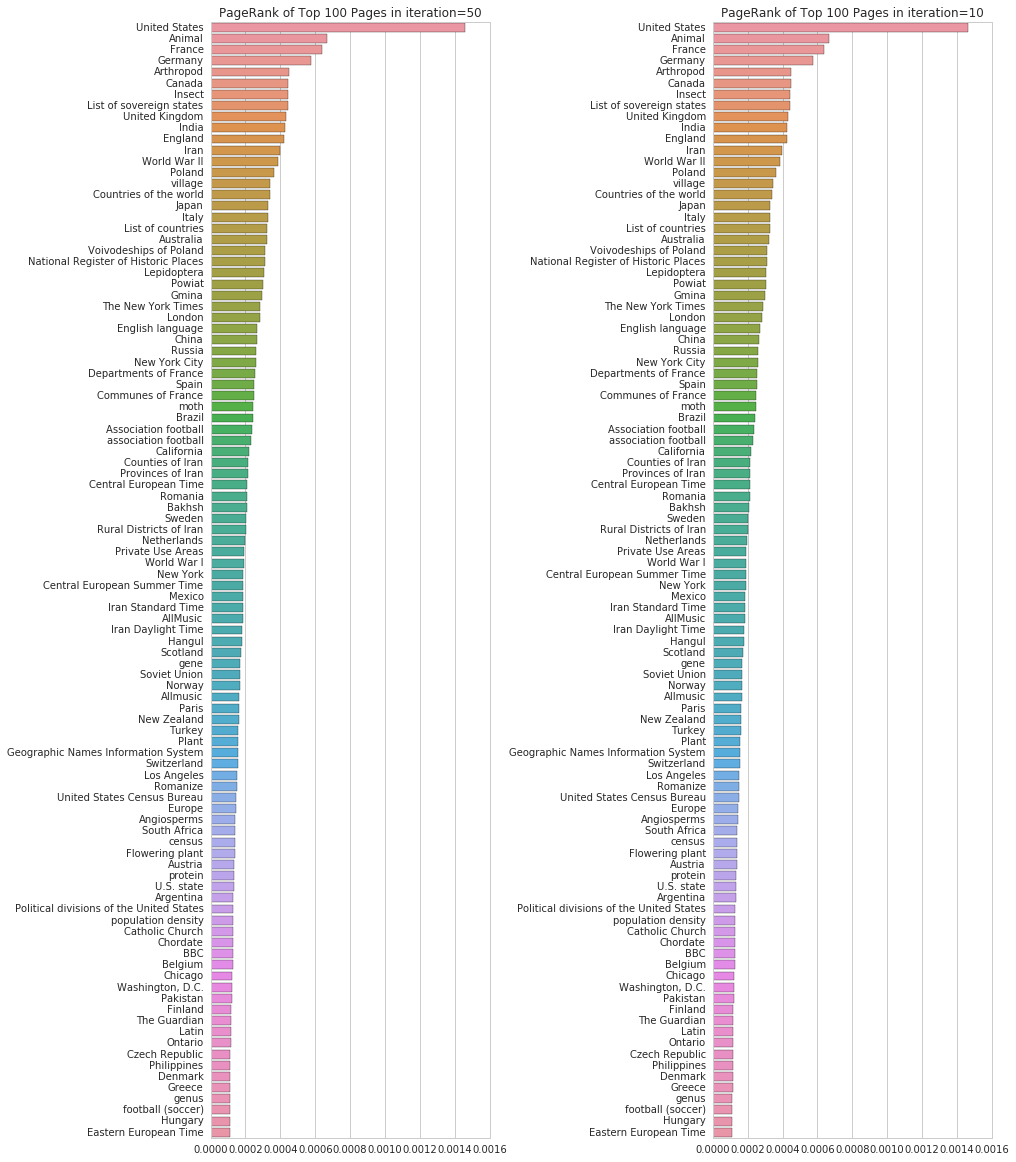

In [49]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 20))
plt.subplots_adjust(wspace=0.8)
plt.subplot(1,2,1)
plot_top_100_pages(top100_pageranks_50, top100_page_names, "PageRank of Top 100 Pages in iteration=50")
plt.subplot(1,2,2)
plot_top_100_pages(top100_pageranks_10, top100_page_names, "PageRank of Top 100 Pages in iteration=10")

Pages whose rankings changed (from 10th to 50th iteration):
[(u'New York', 50, 49), (u'Central European Summer Time', 49, 50)]

The number of pages whose rank values changed (from 10th to 50th iteration):
100


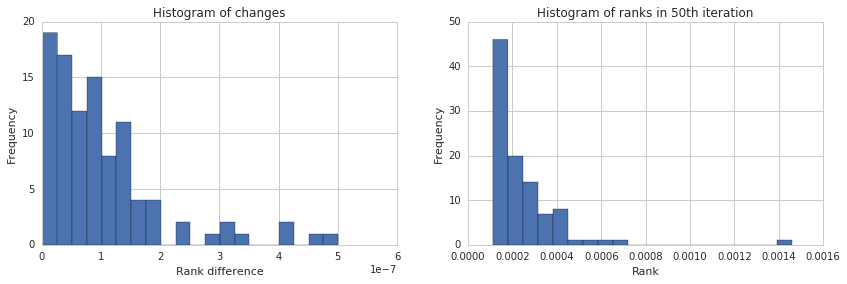

In [72]:
import numpy as np

def report_pageranks_change(top100_pageranks_50, top100_pageranks_10, top100_page_names):
    top100_pageranks_50 = {ID: (i, rank) for i, (ID, rank) in enumerate(top100_pageranks_50)}
    top100_pageranks_10 = {ID: (i, rank) for i, (ID, rank) in enumerate(top100_pageranks_10)}

    rank_changes = []
    rank_value_changes = []
    for ID, (i, rank) in top100_pageranks_50.iteritems():
        if i != top100_pageranks_10[ID][0]:
            rank_changes.append((top100_page_names[ID], top100_pageranks_10[ID][0], i))

        rank_value_changes.append((top100_page_names[ID], top100_pageranks_10[ID][1] - rank))
    print "Pages whose rankings changed (from 10th to 50th iteration):"
    print rank_changes
    print
    
    print "The number of pages whose rank values changed (from 10th to 50th iteration):"
    print len([ID for ID, change in rank_value_changes if change != 0])
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.hist([np.absolute(change) for ID, change in rank_value_changes if change != 0], bins=20)
    plt.title("Histogram of changes")
    plt.xlabel("Rank difference")
    plt.ylabel("Frequency")
    
    plt.subplot(1,2,2)
    plt.hist([rank for ID, (i, rank) in top100_pageranks_50.iteritems()], bins=20)
    plt.title("Histogram of ranks in 50th iteration")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")

report_pageranks_change(top100_pageranks_50, top100_pageranks_10, top100_page_names)

Only the ranking of __New York__ and __Central European Summer Time__ swapped between 10th and 50th iterations. __New York__ moved up from 50th to 49th whereas __Central European Summer Time__ moved down from 49th to 50th. Although the rank values for all pages changes between 10th and 50th iterations, the difference is non-trivial as can be seen from the barplot and histogram above. The change (order of $10^{-7}$) is significantly smaller than the rank values (order of $10^{-4}$).

## HW 13.3: Spark GraphX versus your implementation of PageRank
>Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85).

>Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

> Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explaing the differences. 

> Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implemnentation. Comment on your findings. Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

Spark Stand Alone  Configuration:
- master instance: r3.xlarge
- core instance: 4 * r3.xlarge

### Link to zeppelin notebook for the GraphX code

https://www.zeppelinhub.com/viewer/notebooks/aHR0cHM6Ly9yYXcuZ2l0aHVidXNlcmNvbnRlbnQuY29tL3ZpbmNlbnRjaGlvL2RzMjYxLWczL21hc3Rlci9hMTMvbm90ZS5qc29uP3Rva2VuPUFMM0o1QTBmd3dRcDJMWDdZSmFLT09NX2d3NmtCd0xza3M1WEttdmF3QSUzRCUzRA

In [52]:
#copy files from aws to local for graphs 
!aws s3 cp s3://hvcemrbucket/output/hw13/graphx_50_id/part-00000 ./data/rank_50.txt
!aws s3 cp s3://hvcemrbucket/output/hw13/graphx_10_id/part-00000 ./data/rank_10.txt

download: s3://hvcemrbucket/output/hw13/graphx_50_id/part-00000 to data/rank_50.txt
download: s3://hvcemrbucket/output/hw13/graphx_10_id/part-00000 to data/rank_10.txt


In [53]:
#script to load data from files 
rank_10 = [line.strip("\n").split("\t") for line in open('./data/rank_10.txt')]
rank_10.sort(key=lambda tup: float(tup[2]),reverse=True) 
labels_10 = [row[1] for row in rank_10]
ranks_10 = [float(row[2]) for row in rank_10]

rank_50 = [line.strip("\n").split("\t") for line in open('./data/rank_50.txt')]
rank_50.sort(key=lambda tup: float(tup[2]),reverse=True) 
labels_50 = [row[1] for row in rank_50]
ranks_50 = [float(row[2]) for row in rank_50]

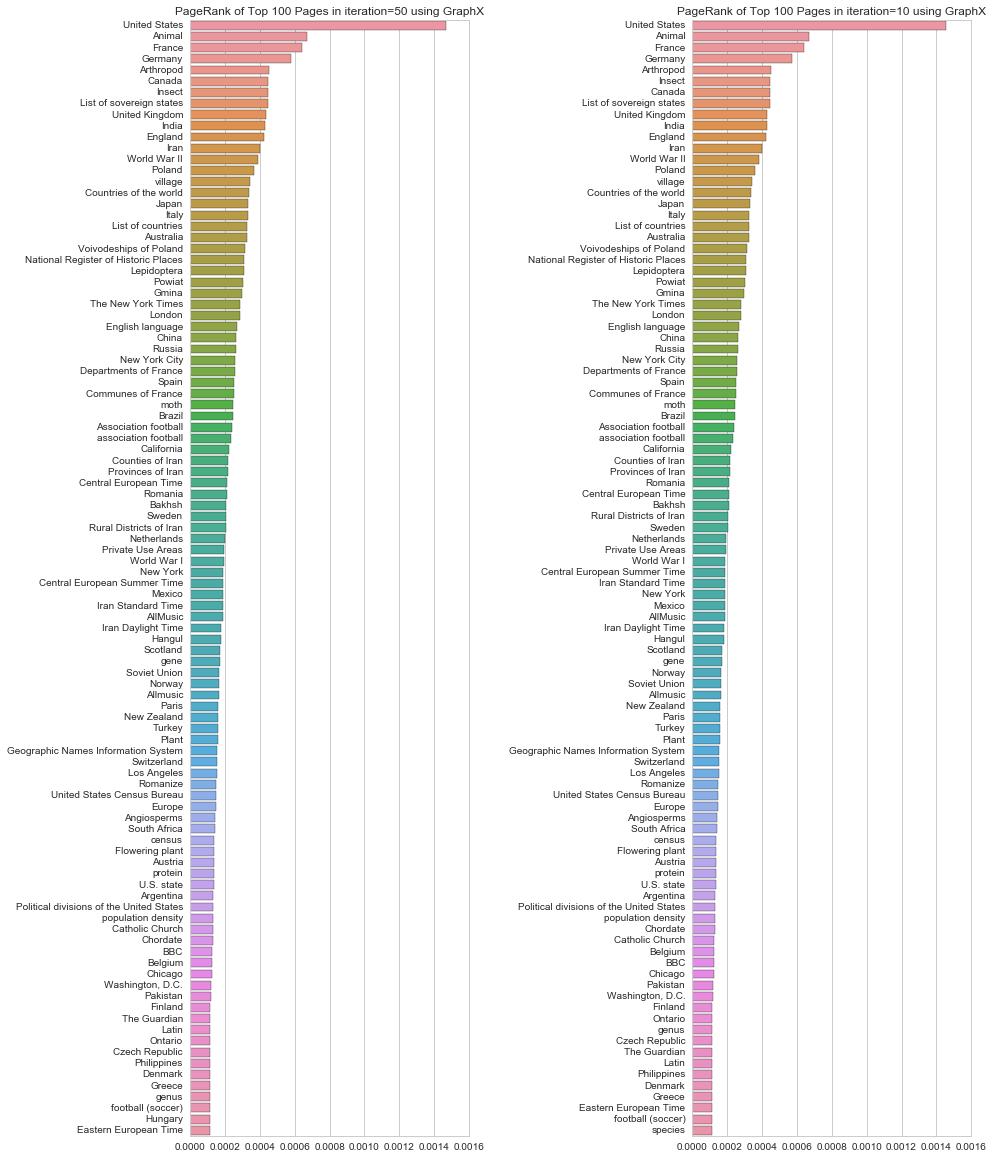

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(14, 20))
plt.subplots_adjust(wspace=0.8)
plt.subplot(1,2,1)
sns.barplot(ranks_50, labels_50)
plt.title("PageRank of Top 100 Pages in iteration=50 using GraphX")
plt.subplot(1,2,2)
sns.barplot(ranks_10, labels_10)
plt.title("PageRank of Top 100 Pages in iteration=10 using GraphX")

Looking at the plot above we can say that there has been change in pagerank values for below wikipedia index. Some of them are document below. 

|Wikipedia Index | Rank in 10 Iterations | Rank in 50 Iterations|
|----------------|-----------------------|----------------------|
|Candada|7|6|
|Insect|6|7|
|Romania|42|43|
|Central European Time|43|42|
|Rural Districts of Iran|45|46|
|Sweden|46|45|
|Central European Summer Time|50|51|
|Iran Standard Time|51|53|
|New York|52|50|
|Mexico|53|52|
|Norway|59|60|
|Soviet Union|60|59|
|New Zealand|62|63
|Paris|63|62
|Chordate|82|83|
|Catholic Church|83|82|
|Belgium|84|85|
|BBC|85|84|
|Pakistan|87|88|
|Washington, D.C.|88|87|
|Ontario|90|92|
|genus|91|97|
|The Guardian|93|90|
|Latin|94|91|
|Philippines|95|94|
|Denmark|96|95|
|Greece|97|96|
|Eastern European Time|98|100|
|football (soccer)|99|98|
|species|100|NA|

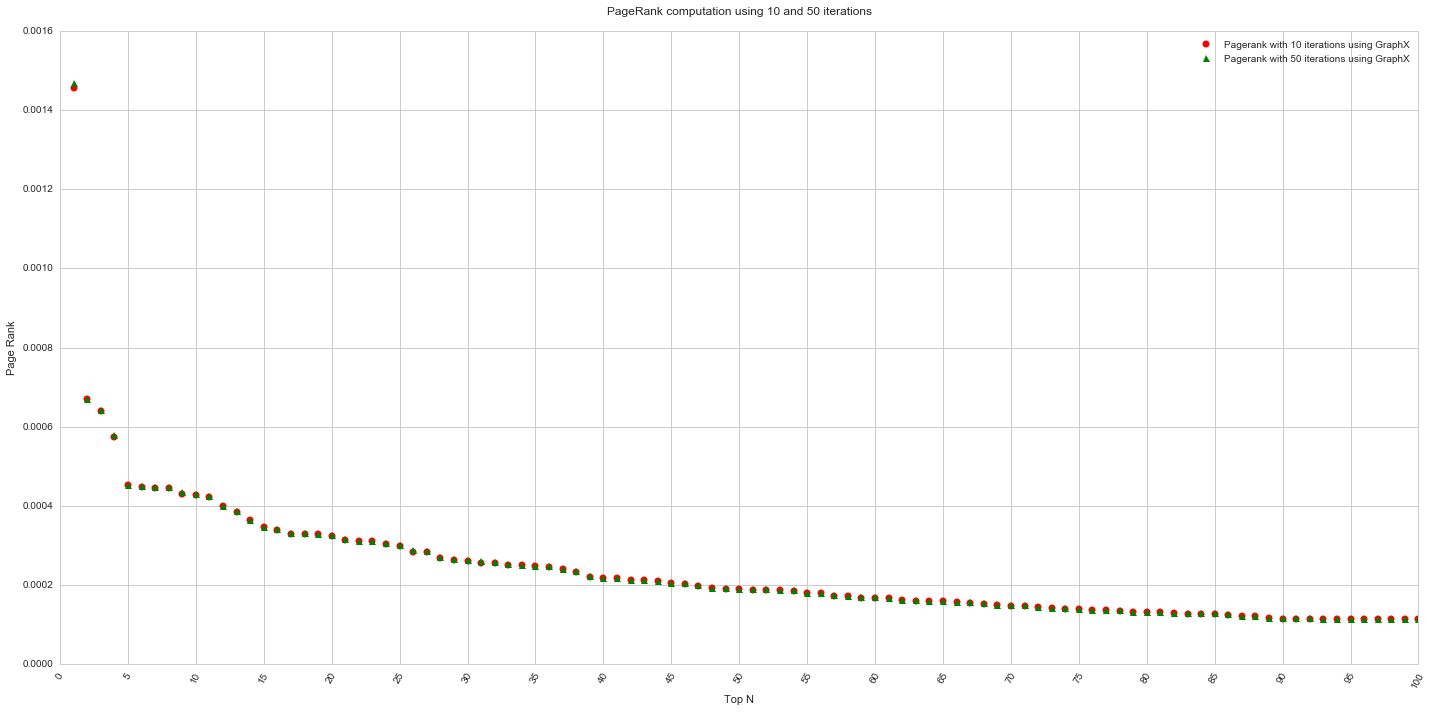

In [117]:
import numpy as np
x=range(1,101)
fig, ax = plt.subplots()
fig.set_size_inches(20, 10, forward=True)
ax.plot(x, ranks_10, 'ro', label='Pagerank with 10 iterations using GraphX')
ax.plot(x, ranks_50, 'g^', label='Pagerank with 50 iterations using GraphX')
ax.set_title("PageRank computation using 10 and 50 iterations\n")
ax.set_ylabel('Page Rank')
ax.set_xlabel('Top N')
plt.xticks(np.arange(0,101,5), rotation='60')
plt.tight_layout()
legend = ax.legend(loc='upper right', shadow=True)
plt.show()

### Comparing GraphX and homegrown pagerank code

| Implementation              | Cluster Size                        |Runtime: 10 Iterations | Runtime: 50 Iterations |
|-----------------------------|--------------|-----------------------|------------------------|
| HomeGrown                   | master instance: m4.large, core instance: 4 * r3.xlarge | 2823.074|11468 secs |
| Graphx PageRank             | master instance: r3.xlarge, core instance: 4 * r3.xlarge| 191 secs |  7062 secs |

GraphX PageRank algorithm is faster compared to our homegrown solution as there is less overhead of writing and reading data. 

#### Comparing pagerank algorithm for top 100 pages between GraphX and homegrown solution with 50 iterations

As seen from the plot below , we dont see any difference in pagerank values between homwgrown Pagerank algorithm and Graphx Pagerank algorithm.

In [135]:
#script to load data from files 
pagerank_rank_50 = [line.strip("\n").strip(" ").split(",") for line in open('/Users/hetal/programming/W261/UCB_MIDS_W261/hw13/top100_50.txt')]
pagerank_rank_50.sort(key=lambda tup: float(tup[1]),reverse=True)
page_ranks_50 = [float(row[1]) for row in pagerank_rank_50]
page_labels_50 = [row[2] for row in pagerank_rank_50]

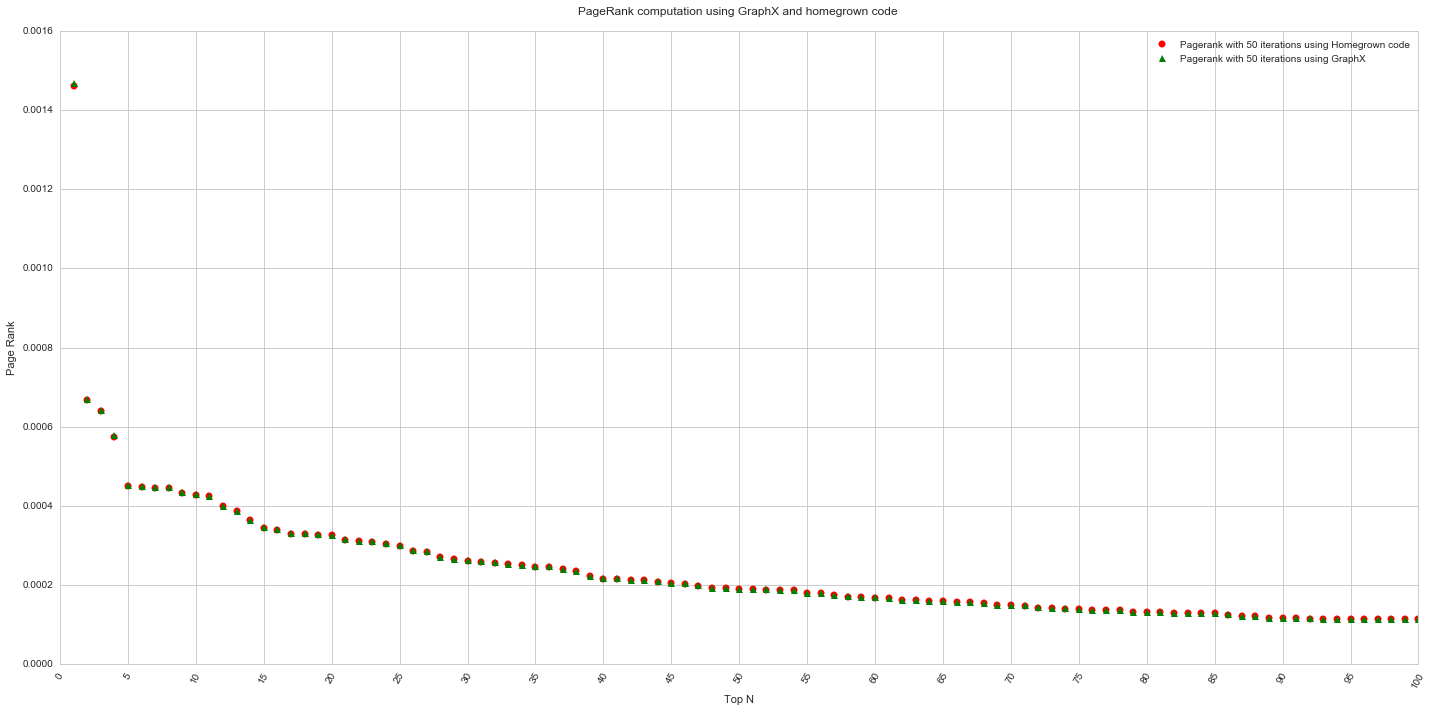

In [134]:
import numpy as np
x=range(1,101)
fig, ax = plt.subplots()
fig.set_size_inches(20, 10, forward=True)
ax.plot(x, page_ranks_50, 'ro', label='Pagerank with 50 iterations using Homegrown code')
ax.plot(x, ranks_50, 'g^', label='Pagerank with 50 iterations using GraphX')
ax.set_title("PageRank computation using GraphX and homegrown code \n")
ax.set_ylabel('Page Rank')
ax.set_xlabel('Top N')
plt.xticks(np.arange(0,101,5), rotation='60')
plt.tight_layout()
legend = ax.legend(loc='upper right', shadow=True)
plt.show()

## HW 13.4: Criteo Phase 2 baseline
> The Criteo data for this challenge is located in the following S3/Dropbox buckets:

>On Dropbox see:
- https://www.dropbox.com/sh/dnevke9vsk6yj3p/AABoP-Kv2SRxuK8j3TtJsSv5a?dl=0

>Raw Data:  (Training, Validation and Test data)
- https://criteo-dataset.s3.amazonaws.com/rawdata

>Hashed Data: Training, Validation and Test data in hash encoded (10,000 buckets) and sparse representation
- https://criteo-dataset.s3.amazonaws.com/processeddata


>Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:
- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparamters:
- Number of buckets for hashing: 1,000
- Logistic Regression: no regularization term
- Logistic Regression: step size = 10

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets. Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above each table).

In [5]:
import pandas as pd
import datetime as DT
import numpy as np

In [6]:
from collections import defaultdict
import hashlib
import numpy as np
from math import exp
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.classification import LogisticRegressionWithSGD

class CriteoLRModel:
    @staticmethod
    def hashFunction(numBuckets, rawFeats, printMapping=False):
        """Calculate a feature dictionary for an observation's features based on hashing.

        Note:
            Use printMapping=True for debug purposes and to better understand how the hashing works.

        Args:
            numBuckets (int): Number of buckets to use as features.
            rawFeats (list of (int, str)): A list of features for an observation.  Represented as
                (featureID, value) tuples.
            printMapping (bool, optional): If true, the mappings of featureString to index will be
                printed.

        Returns:
            dict of int to float:  The keys will be integers which represent the buckets that the
                features have been hashed to.  The value for a given key will contain the count of the
                (featureID, value) tuples that have hashed to that key.
        """
        mapping = {}
        for ind, category in rawFeats:
            featureString = category + str(ind)
            mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
        if(printMapping): print mapping
        sparseFeatures = defaultdict(float)
        for bucket in mapping.values():
            sparseFeatures[bucket] += 1.0
        return dict(sparseFeatures)

    @staticmethod
    def parseHashPoint(point, numBuckets, sep=','):
        """Create a LabeledPoint for this observation using hashing.

        Args:
            point (str): A comma separated string where the first value is the label and the rest are
                features.
            numBuckets: The number of buckets to hash to.
            sep: The separator of the input features.

        Returns:
            LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
                features.
        """
        data = point.split(sep)
        label = data[0]
        features = data[1:]
        indexed_features = [(i, feature) for i, feature in enumerate(features)]
        return LabeledPoint(data[0], SparseVector(numBuckets, CriteoLRModel.hashFunction(numBuckets, indexed_features)))

    @staticmethod
    def getP(x, w, intercept):
        """Calculate the probability for an observation given a set of weights and intercept.

        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.

        Args:
            x (SparseVector): A vector with values of 1.0 for features that exist in this
                observation and 0.0 otherwise.
            w (DenseVector): A vector of weights (betas) for the model.
            intercept (float): The model's intercept.

        Returns:
            float: A probability between 0 and 1.
        """
        rawPrediction = x.dot(w) + intercept

        # Bound the raw prediction value
        rawPrediction = min(rawPrediction, 20)
        rawPrediction = max(rawPrediction, -20)
        return 1 / (1 + exp(-rawPrediction))
    
    @staticmethod
    def computeLogLoss(p, y):
        """Calculates the value of log loss for a given probabilty and label.

        Note:
            log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
            and when p is 1 we need to subtract a small value (epsilon) from it.

        Args:
            p (float): A probabilty between 0 and 1.
            y (int): A label.  Takes on the values 0 and 1.

        Returns:
            float: The log loss value.
        """
        epsilon = 10e-12
        p = p if y == 1 else 1 - p
        if p == 1:
            p -= epsilon
        elif p == 0:
            p += epsilon
        return -np.log(p)

    @staticmethod
    def evaluateLogLossResults(model, data):
        """Calculates the log loss for the data given the model.

        Args:
            model (LogisticRegressionModel): A trained logistic regression model.
            data (RDD of LabeledPoint): Labels and features for each observation.

        Returns:
            float: Log loss for the data.
        """
        return data.map(
            lambda p: CriteoLRModel.computeLogLoss(
                CriteoLRModel.getP(p.features, model.weights, model.intercept), p.label)).\
            mean()
    
    @staticmethod
    def evaluateAUCResults(model, data):
        scoreAndLabels = data.map(
            lambda p: (CriteoLRModel.getP(p.features, model.weights, model.intercept), p.label))
        metrics = BinaryClassificationMetrics(scoreAndLabels)
        return metrics.areaUnderROC

    @staticmethod
    def train(hashTrainData, numIters, stepSize, regParam, regType, includeIntercept):
        return LogisticRegressionWithSGD.train(
            hashTrainData, numIters, stepSize,
            regParam=regParam, regType=regType,
            intercept=includeIntercept)

In [3]:
def prepare_data_rdd(sc, path):
    weights = [.8, .1, .1]
    seed = 42
    rawTrainData, rawValidationData, rawTestData = sc.textFile(path).randomSplit(weights, seed=seed)
    rawTrainData.cache()
    rawValidationData.cache()
    rawTestData.cache()
    return rawTrainData, rawValidationData, rawTestData

def raw_to_hash_feature(rdd, numBuckets, sep=','):
    return rdd.map(lambda point: CriteoLRModel.parseHashPoint(point, numBuckets, sep))

In [4]:
rawTrainData = sc.textFile("s3://criteo-dataset/rawdata/train/part-*").cache()
rawValidationData = sc.textFile("s3://criteo-dataset/rawdata/validation/part-*").cache()
rawTestData = sc.textFile("s3://criteo-dataset/rawdata/test/part-*").cache()

In [5]:
hashTrainData = raw_to_hash_feature(rawTrainData, 1000, sep='\t').cache()
hashValidationData = raw_to_hash_feature(rawValidationData, 1000, sep='\t').cache()
hashTestData = raw_to_hash_feature(rawTestData, 1000, sep='\t').cache()

In [7]:
def hw13_4():
    results = {}
    results['TrainLogLoss'] = []
    results['ValidationLogLoss'] = []
    results['TestLogLoss'] = []
    results['TrainAUC'] = []
    results['ValidationAUC'] = []
    results['TestAUC'] = []
    starttime = DT.datetime.now()
    model = CriteoLRModel.train(hashTrainData, 100, 10, 0, None, True)
    results['TrainLogLoss'].append(CriteoLRModel.evaluateLogLossResults(model, hashTrainData))
    results['ValidationLogLoss'].append(CriteoLRModel.evaluateLogLossResults(model, hashValidationData))
    results['TestLogLoss'].append(CriteoLRModel.evaluateLogLossResults(model, hashTestData))
    results['TrainAUC'].append(CriteoLRModel.evaluateAUCResults(model, hashTrainData))
    results['ValidationAUC'].append(CriteoLRModel.evaluateAUCResults(model, hashValidationData))
    results['TestAUC'].append(CriteoLRModel.evaluateAUCResults(model, hashTestData))
    
    endtime = DT.datetime.now()
    runtime = (endtime-starttime).seconds
    runtime_hours = runtime // 3600
    runtime_minutes = (runtime % 3600) // 60
    runtime_seconds = (runtime % 3600) % 60
    print 'job finished in {} hours, {} minutes and {} seconds'.\
            format(runtime_hours, runtime_minutes, runtime_seconds)
    print results

hw13_4()


job finished in 0 hours, 17 minutes and 23 seconds


In [8]:
pd.DataFrame(results)

,TestAUC,TestLogLoss,TrainAUC,TrainLogLoss,ValidationAUC,ValidationLogLoss
0,0.724797,0.505603,0.724549,0.505464,0.724326,0.505676


#### AWS Configuration
10 r3.xlarge nodes, 9 executors with 4-cores each, 20G per executor. 

## HW 13.5: Criteo Phase 2 hyperparameter tuning
>Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:
- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.
- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

>Discuss the optimal setting to solve this problem  in terms of the following:
- Features
- Learning algortihm
- Spark cluster

>Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.


##### run grid-search

In [7]:
gsresults = {}
def hw13_5():
    starttime = DT.datetime.now()
    gsresults = {}
    gsresults['HashBucket'] = []
    gsresults['StepSize'] = []
    gsresults['RegParam'] = []
    gsresults['ValidationLogLoss'] = []
    gsresults['ValidationAUC'] = []
    buckets = [1000, 10000, 50000]
    stepSizes = [1, 3, 6, 9]
    regParams = [1e-6, 1e-3, 1]
    models = {}
    
    for bucket in buckets:
        hashTrainData = raw_to_hash_feature(rawTrainData, bucket, sep='\t').cache()
        hashValidationData = raw_to_hash_feature(rawValidationData, bucket, sep='\t').cache()
        for stepSize in stepSizes:
            for regParam in regParams:
                model = CriteoLRModel.train(hashTrainData, 20, stepSize, regParam, 'l2', True)
                gsresults['HashBucket'].append(bucket)
                gsresults['StepSize'].append(stepSize)
                gsresults['RegParam'].append(regParam)
                gsresults['ValidationLogLoss'].append(CriteoLRModel.evaluateLogLossResults(model, hashValidationData))
                gsresults['ValidationAUC'].append(CriteoLRModel.evaluateAUCResults(model, hashValidationData))
    
    endtime = DT.datetime.now()
    runtime = (endtime-starttime).seconds
    runtime_hours = runtime // 3600
    runtime_minutes = (runtime % 3600) // 60
    runtime_seconds = (runtime % 3600) % 60
    print 'job finished in {} hours, {} minutes and {} seconds'.\
            format(runtime_hours, runtime_minutes, runtime_seconds)
    print gsresults

hw13_5()

job finished in 1 hours, 15 minutes and 15 seconds


#### Figure 1: All grid-search results

In [4]:
pd.DataFrame(gsresults)

,HashBucket,RegParam,StepSize,ValidationAUC,ValidationLogLoss
0,1000,0.000001,1,0.672522,0.536981
1,1000,0.001000,1,0.672526,0.537034
2,1000,1.000000,1,0.623219,0.574574
3,1000,0.000001,3,0.699700,0.520660
4,1000,0.001000,3,0.699663,0.520774
5,1000,1.000000,3,0.652864,0.758756
6,1000,0.000001,6,0.702562,0.591059
7,1000,0.001000,6,0.709711,0.560572
8,1000,1.000000,6,0.485760,8.208095
9,1000,0.000001,9,0.700916,0.801807


#### Figure 2a: Best grid-search results, log-loss

In [7]:
result_df = pd.DataFrame(gsresults)
bestresult = result_df['ValidationLogLoss']==np.min(result_df['ValidationLogLoss'])
result_df[bestresult]

,HashBucket,RegParam,StepSize,ValidationAUC,ValidationLogLoss
30,50000,0.000001,6,0.716223,0.516965


#### Figure 2b: Best grid-search results, AUC

In [44]:
result_df = pd.DataFrame(gsresults)
bestresult = result_df['ValidationAUC']==np.max(result_df['ValidationAUC'])
result_df[bestresult]

,HashBucket,RegParam,StepSize,ValidationAUC,ValidationLogLoss
34,50000,0.001,9,0.719289,0.601421


> **Figures 2a & 2b**  The best grid-search results for log-loss are step size of 6 and regularization of 1e-06. The best grid-search results for AUC are step-size of 9 and regularization of 0.001. The best results for AUC and for log-loss are both with a hash bucket size of 50,000 features.

##### train model using best parameters

In [7]:
# use best results
hashBuckets = 50000
regTerm = 0.000001
stepSize = 6

# build datasets with best grid-search results
hashTrainData = raw_to_hash_feature(rawTrainData, hashBuckets, sep='\t').cache() 
hashValidationData = raw_to_hash_feature(rawValidationData, hashBuckets, sep='\t').cache()
hashTestData = raw_to_hash_feature(rawTestData, hashBuckets, sep='\t').cache()

# create LR model 
modelGS = CriteoLRModel.train(hashTrainData, 100, stepSize, regTerm, 'l2', True)

print "Grid-search Log-loss for train (%.3f), validation (%.3f) and test data (%.3f)" % (
        CriteoLRModel.evaluateLogLossResults(modelGS, hashTrainData),
        CriteoLRModel.evaluateLogLossResults(modelGS, hashValidationData),
        CriteoLRModel.evaluateLogLossResults(modelGS, hashTestData),
    )
print "Grid-search AUC for train (%.3f), validation (%.3f) and test data (%.3f)" % (
        CriteoLRModel.evaluateAUCResults(modelGS, hashTrainData),
        CriteoLRModel.evaluateAUCResults(modelGS, hashValidationData),
        CriteoLRModel.evaluateAUCResults(modelGS, hashTestData),
    )

Grid-search Log-loss for train (0.502), validation (0.502) and test data (0.502)
Grid-search AUC for train (0.732), validation (0.732) and test data (0.732)


##### generate plots

In [8]:
# plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
%matplotlib inline

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

#### Figure 3: Log-loss Heatmap

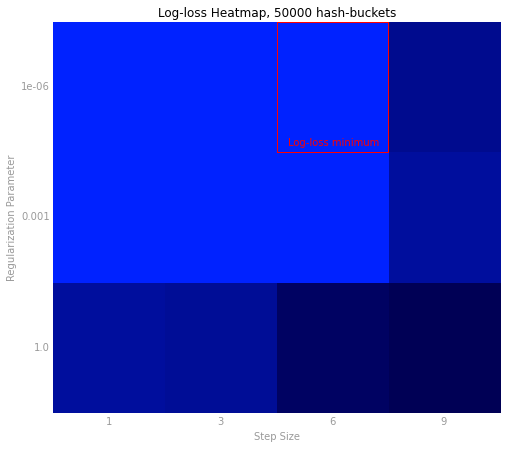

In [46]:
gs = pd.DataFrame(gsresults)
best = gs['HashBucket'] == hashBuckets
gs = gs.loc[best,:]
regTerms = sorted ( set( gs.loc[:,'RegParam'] ))
stepSizes = sorted ( set( gs.loc[:,'StepSize'] ))
p = []
for r in regTerms:
    for s in stepSizes:
        v = gs.loc[(gs['RegParam']==r) & (gs['StepSize']==s)]['ValidationLogLoss'].iloc[0]
        p.append(v)

logLoss = np.array( p )
numRows, numCols = len(regTerms), len(stepSizes)
logLoss.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
ax.set_yticklabels(regTerms), ax.set_xticklabels(stepSizes)
ax.set_ylabel('Regularization Parameter'), ax.set_xlabel('Step Size')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.1)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)
ax.set_title('Log-loss Heatmap, {} hash-buckets'.format(hashBuckets))
ax.add_patch(patches.Rectangle((1.5,-.5),1,1,fill=False,color='red'))
ax.annotate('Log-loss minimum', xy=(1.5,1),xytext=(1.6, .45), color='red')

>**Figure 3** The lowest log-loss occures when step-size is less-than 9 and regularization is below 1.0. The region highlighted in red is the minimum log-loss point, where stepsize is 6 and regularization is 1e-06.

#### Figure 4: AUC Heatmap

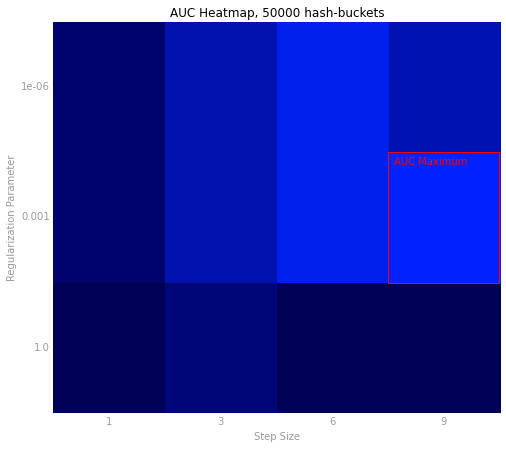

In [67]:
gs = pd.DataFrame(gsresults)
best = gs['HashBucket'] == hashBuckets
gs = gs.loc[best,:]
regTerms = sorted ( set( gs.loc[:,'RegParam'] ))
stepSizes = sorted ( set( gs.loc[:,'StepSize'] ))
p = []
for r in regTerms:
    for s in stepSizes:
        v = gs.loc[(gs['RegParam']==r) & (gs['StepSize']==s)]['ValidationAUC'].iloc[0]
        p.append(v)

logLoss = np.array( p )
numRows, numCols = len(regTerms), len(stepSizes)
logLoss.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
ax.set_yticklabels(regTerms), ax.set_xticklabels(stepSizes)
ax.set_ylabel('Regularization Parameter'), ax.set_xlabel('Step Size')

colors = LinearSegmentedColormap.from_list('blue', ['#000055','#0022ff'], gamma=10)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)
ax.set_title('AUC Heatmap, {} hash-buckets'.format(hashBuckets))
ax.add_patch(patches.Rectangle((2.497,0.5),1,1,fill=False,color='red'))
ax.annotate('AUC Maximum', xy=(2.497,0.5),xytext=(2.55,0.6), color='red')

>**Figure 4**  The maximum AUC (highlighted with red) occurs with step-size of 9 and regularization at 0.001; however, at this point the log-loss is significantly worse as compared with a step-size of 6 and regularization of 1e-06. Further, the AUC is only marginally decreased from the maximium value when using the parameters that minimize log-loss. 

### Our ideal setup:

We utilized the following AWS EMR cluster setup to deliver fast Logistic Regression runtimes of ~1-2 seconds per iteration.

* **AWS cluster setup**
    * 10 r3.xlarge nodes
    * num-executors set at 9
    * executor-memory set at 20gb
    * executor-cores set at 4


* **Optimal logistic regression model parameters**
    *  Step-size: 6  
    *  Regularization: 1e-06  
    *  Hash-buckets: 50,000  
    
The regression model with 50,000 features, step-size 6 and regularization at 1e-06 had the minimum log-loss from our grid-search results (Figure 1). As shown in Figure 2, log-loss is minimized at regularization of 1e-06 and step size of 6. As illustrated in the heatmap in Figure 3, there is very little difference between different combinations of step-size between 1 and 6 and regularization between 0.001 and 1e-06. As Figure 4 shows, AUC is minimized at a step-size of 9 and regularization of 0.001; however, at this point the log-loss is significantly worse than the best grid-search result for log-loss, and further, at the best point for log-loss there is only a very slight reduction in AUC from the maximum grid-search result. Thus, the ideal point is the balance of AUC and log-loss -- step size of 6, regularization of 1e-06, and hash-bucket features at 50,000.
